In [ ]:
pip install trjtrypy

In [ ]:
#pip install tslearn

# Libraries

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
import trjtrypy as tt
from trjtrypy.featureMappings import curve2vec

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# install package

In [ ]:
# to make a directory
%cd 'gdrive/My Drive/traj-dist'

/content/gdrive/My Drive/traj-dist


In [ ]:
pwd

'/content/gdrive/My Drive/traj-dist'

In [ ]:
# to install setup.py from the current directory
!python setup.py install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/lib/python3.7/distutils/dist.py:274: UserWarning: Unknown distribution option: 'download_urt'
  warnings.warn(msg)
running install
running bdist_egg
running egg_info
writing traj_dist.egg-info/PKG-INFO
writing dependency_links to traj_dist.egg-info/dependency_links.txt
writing requirements to traj_dist.egg-info/requires.txt
writing top-level names to traj_dist.egg-info/top_level.txt
adding license file 'LICENSE.txt'
writing manifest file 'traj_dist.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'traj_dist/cydist/basic_geographical.c' Cython extension (up-to-date)
skipping 'traj_dist/cydist/basic_euclidean.c' Cython extension (up-to-date)
skipping

In [ ]:
!pip install geohash2

# "###################" Now restart runtime "###################"

In [ ]:
import traj_dist.distance as tdist
import pickle

# Read data

In [ ]:
def read_file(file_name):
    data = []
    Data = []
    flag = True
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split("|")
            if flag == True and len(item) == 5:
                data.append([float(item[0]), float(item[1])])
                Data.append([float(item[3]), float(item[4])])
                flag = False
            elif flag == True and len(item) == 6:
                data.append([float(item[0]), float(item[1])])
                Data.append([float(item[3]), float(item[4])])
                flag = False
            else:
                flag = True
    return np.array(data), np.array(Data)

In [ ]:
P1 = glob.glob('/content/gdrive/My Drive/Research/Persons data/person1/**/', recursive=True)[1:]
P2 = glob.glob('/content/gdrive/My Drive/Research/Persons data/person2/**/', recursive=True)[1:]
I1 = glob.glob('/content/gdrive/My Drive/Research/Persons data/person1/**/*.txt', recursive=True)
I2 = glob.glob('/content/gdrive/My Drive/Research/Persons data/person2/**/*.txt', recursive=True)

In [ ]:
A = pd.read_csv(I1[0], header=None, delimiter="|")
np.array(A)

array([[4151.7448, 8739.0343, ' -5:09:12 ', 221.635987, 358.560798],
       [4151.7404, 8739.0384, ' -5:09:22 ', 221.632501, 358.555709],
       [4151.7418, 8739.0387, ' -5:09:23 ', 221.632231, 358.557317],
       ...,
       [4147.5155, 8806.6687, ' -5:43:28 ', 197.887199, 353.570877],
       [4147.5141, 8806.6688, ' -5:43:29 ', 197.887118, 353.569267],
       [4147.5126, 8806.6689, ' -5:43:30 ', 197.887036, 353.5675]],
      dtype=object)

In [ ]:
len(P1), len(P2), len(I1), len(I2), len(I1)/len(I2)

(68, 35, 124, 89, 1.3932584269662922)

In [ ]:
data1_lan_long = [0] * len(I1) # trajectories in lan,long-coordinates
data1_x_y = [0] * len(I1) # trajectories in projected x,y-coordinate
data2_lan_long = [0] * len(I2) # trajectories in lan,long-coordinates
data2_x_y = [0] * len(I2) # trajectories in projected x,y-coordinate

for i in range(len(I1)):
    z =read_file(I1[i])
    data1_lan_long[i] = z[0]
    data1_x_y[i] = z[1]

for i in range(len(I2)):
    z =read_file(I2[i])
    data2_lan_long[i] = z[0]
    data2_x_y[i] = z[1]
    
data1_lan_long = np.array(data1_lan_long, dtype = 'object')
data1_x_y = np.array(data1_x_y, dtype = 'object')
data2_lan_long = np.array(data2_lan_long, dtype = 'object')
data2_x_y = np.array(data2_x_y, dtype = 'object')

In [ ]:
data1_lan_long = data1_x_y
data2_lan_long = data2_x_y

In [ ]:
def remove_segments(traj): # removes stationary points
    p2 = traj[1:]
    p1 = traj[:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

In [ ]:
data1_lan_long = np.array([remove_segments(data1_lan_long[i]) for i in range(len(data1_lan_long))])

data2_lan_long = np.array([remove_segments(data2_lan_long[i]) for i in range(len(data2_lan_long))])

len(data1_lan_long), len(data2_lan_long)

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


(124, 89)

In [ ]:
L1 = np.array([len(data1_lan_long[i]) for i in range(len(data1_lan_long))])
L2 = np.array([len(data2_lan_long[i]) for i in range(len(data2_lan_long))])
    
len(np.where(L1 < 2500)[0]), len(np.where(L2 < 2000)[0])

(93, 88)

In [ ]:
np.sort(L1)

array([  70,   92,  120,  139,  144,  188,  203,  229,  263,  266,  284,
        293,  294,  310,  323,  359,  373,  385,  416,  424,  427,  427,
        431,  447,  472,  675,  838,  844,  846,  895,  923,  927,  957,
        984, 1000, 1009, 1010, 1035, 1057, 1077, 1097, 1156, 1160, 1178,
       1179, 1206, 1219, 1226, 1227, 1331, 1357, 1372, 1384, 1459, 1471,
       1656, 1729, 1822, 1899, 1902, 1908, 1909, 1924, 1925, 1932, 1942,
       1948, 1949, 1957, 1994, 2006, 2045, 2065, 2065, 2083, 2098, 2098,
       2117, 2146, 2181, 2206, 2234, 2259, 2290, 2325, 2374, 2398, 2419,
       2422, 2431, 2464, 2475, 2486, 2505, 2505, 2506, 2527, 2573, 2576,
       2594, 2609, 2616, 2663, 2672, 2673, 2683, 2781, 2870, 3013, 3121,
       3128, 3150, 3197, 3239, 3307, 3383, 3417, 3424, 3807, 3864, 3965,
       4053, 4414, 5493])

In [ ]:
np.sort(L2)

array([  72,   92,   93,   95,  131,  139,  143,  145,  153,  164,  165,
        179,  179,  180,  186,  188,  188,  192,  205,  207,  213,  214,
        216,  219,  225,  248,  248,  254,  255,  257,  258,  260,  260,
        263,  263,  275,  276,  276,  278,  281,  285,  286,  290,  290,
        293,  295,  299,  310,  315,  317,  334,  339,  339,  349,  349,
        357,  371,  376,  381,  382,  388,  388,  394,  395,  409,  440,
        446,  447,  458,  465,  468,  473,  476,  481,  483,  483,  496,
        502,  513,  515,  605,  610,  631,  634,  644,  645,  752, 1465,
       2686])

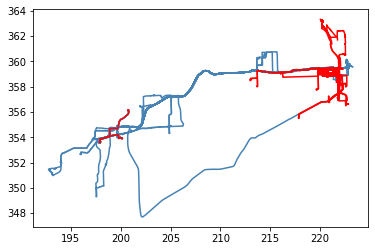

In [ ]:
for k in range(len(data1_lan_long)):
    plt.plot(data1_lan_long[k][:,0], data1_lan_long[k][:,1], color = "steelblue");
for k in range(len(data2_lan_long)):
    plt.plot(data2_lan_long[k][:,0], data2_lan_long[k][:,1], color = "red");
plt.show()

In [ ]:
import trjtrypy as tt
from trjtrypy.featureMappings import curve2vec

def ExpCurve2Vec(points,curves,mu):
    D=tt.distsbase.DistsBase()
    return [np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves]

In [ ]:
sigma = 10
n_1 = len(data1_lan_long)
n_2 = len(data2_lan_long)
Q = np.array([[208.47169065, 358.8011311 ],
       [215.66498507, 356.51173626],
       [197.95927813, 358.10100818],
       [207.8932129 , 354.66994672],
       [202.46234057, 357.65275419],
       [206.6951825 , 359.67975683],
       [203.37120223, 360.23069571],
       [209.32336545, 355.3536409 ],
       [207.05488195, 354.4045235 ],
       [205.13106652, 358.4823325 ]])

projected_1 = np.concatenate((curve2vec(Q, data1_lan_long, version='signed', sigma=sigma), 
                              np.ones(n_1).reshape(n_1,1)), axis=1)

projected_2 = np.concatenate((curve2vec(data1_lan_long[0][:10]+1, data2_lan_long, version='signed', sigma=sigma), 
                              -np.ones(n_2).reshape(n_2,1)), axis=1)

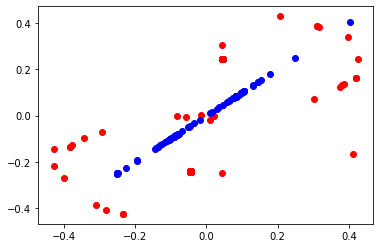

In [ ]:
x = projected_1[:,0]
y = projected_1[:,1]

u = projected_2[:,0]
v = projected_2[:,1]

plt.scatter(x, y, color= 'red')
plt.scatter(u, v, color= 'blue')
plt.show()

# Classifiers

In [ ]:
CC = [1000, 100, 10]
number_estimators = [50, 50]


clf0 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf1 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf3 = [DecisionTreeClassifier(), "Decision Tree"]
clf4 = [RandomForestClassifier(n_estimators=number_estimators[0]), 
         "RandomForestClassifier, n="+str(number_estimators[0])]
clf5 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf6 = [LogisticRegression(solver='newton-cg'), "Logistic Regression"]

clff = [clf0, clf1, clf2, clf3, clf4, clf5, clf6]
classifs = [item[0] for item in clff]
keys = [item[1] for item in clff]

# Classification with feature mappings $v_Q$, $v_Q^{\sigma}$, $v_Q^{\mu}$ with 20 random landmarks, and endpoints (done)

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

Saving v_Q_mu_endpoints_classification.py to v_Q_mu_endpoints_classification (1).py


## Boost($v_Q$), Boost($v_Q^{\varsigma}$), Boost($v_Q^{\exp}$) with epoch=50 and num_trials_maj=11

In [ ]:
classifs = binaryClassificationAverageMajority(data1_lan_long, data2_lan_long, 
            Q_size=20, epoch=50, num_trials_maj=11, classifiers=clff,
            version='unsigned', test_size=0.3)
classifs.classification_v_Q()[0]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

total time = 605.3209762573242


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C = 1000",0.0382,0.0785,0.0323
2,"Gaussian SVM, C=100, gamma=auto",0.0432,0.0597,0.0203
3,"Poly kernel SVM, C=10, deg=auto",0.0516,0.0622,0.0257
4,Decision Tree,0.0072,0.0806,0.0301
5,"RandomForestClassifier, n=50",0.0072,0.0625,0.0296
6,KNN,0.0504,0.0542,0.0209
7,Logistic Regression,0.0501,0.0572,0.0246


In [ ]:
classifs = binaryClassificationAverageMajority(data1_lan_long, data2_lan_long, 
            Q_size=20, epoch=50, num_trials_maj=11, classifiers=clff,
            version='signed', sigma=100, test_size=0.3)
classifs.classification_v_Q()[0]

total time = 681.019939661026


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C = 1000",0.1782,0.2868,0.0490
2,"Gaussian SVM, C=100, gamma=auto",0.0239,0.0892,0.0287
3,"Poly kernel SVM, C=10, deg=auto",0.0884,0.2197,0.0562
4,Decision Tree,0.0072,0.0963,0.0293
5,"RandomForestClassifier, n=50",0.0072,0.0769,0.0263
6,KNN,0.0753,0.0825,0.0330
7,Logistic Regression,0.3222,0.3492,0.0495


In [ ]:
classifs = binaryClassificationAverageMajority(data1_lan_long, data2_lan_long, 
            Q_size=20, epoch=50, num_trials_maj=11, classifiers=clff, test_size=0.3)
classifs.classification_v_Q_mu()[0]

total time = 585.8470225334167


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C = 1000",0.0461,0.0735,0.0239
2,"Gaussian SVM, C=100, gamma=auto",0.0439,0.0658,0.0267
3,"Poly kernel SVM, C=10, deg=auto",0.0509,0.0615,0.0215
4,Decision Tree,0.0072,0.0714,0.0250
5,"RandomForestClassifier, n=50",0.0072,0.0628,0.0238
6,KNN,0.0493,0.0538,0.0214
7,Logistic Regression,0.0512,0.0572,0.0230


## Rand $v_Q$, Rand $v_Q^{\varsigma}$, Rand $v_Q^{\exp}$ with epoch=50 and num_trials_maj=1

In [ ]:
classifs = binaryClassificationAverageMajority(data1_lan_long, data2_lan_long, 
            Q_size=20, epoch=50, num_trials_maj=1, classifiers=clff,
            version='unsigned', test_size=0.3)
classifs.classification_v_Q()[0]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


total time = 56.496999740600586


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C = 1000",0.0376,0.0892,0.0326
2,"Gaussian SVM, C=100, gamma=auto",0.0428,0.0625,0.0212
3,"Poly kernel SVM, C=10, deg=auto",0.0518,0.0668,0.0259
4,Decision Tree,0.0068,0.1037,0.0384
5,"RandomForestClassifier, n=50",0.0074,0.0692,0.0263
6,KNN,0.0493,0.0578,0.0217
7,Logistic Regression,0.0485,0.0631,0.0243


In [ ]:
classifs = binaryClassificationAverageMajority(data1_lan_long, data2_lan_long, 
            Q_size=20, epoch=50, num_trials_maj=1, classifiers=clff,
            version='signed', sigma=100, test_size=0.3)
classifs.classification_v_Q()[0]

total time = 63.47153329849243


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C = 1000",0.2351,0.3283,0.0725
2,"Gaussian SVM, C=100, gamma=auto",0.0245,0.1102,0.0367
3,"Poly kernel SVM, C=10, deg=auto",0.1108,0.2262,0.0673
4,Decision Tree,0.0069,0.1314,0.0358
5,"RandomForestClassifier, n=50",0.0078,0.0892,0.0234
6,KNN,0.0824,0.0963,0.0342
7,Logistic Regression,0.3162,0.3462,0.0612


In [ ]:
classifs = binaryClassificationAverageMajority(data1_lan_long, data2_lan_long, 
            Q_size=20, epoch=50, num_trials_maj=1, classifiers=clff, test_size=0.3)
classifs.classification_v_Q_mu()[0]

total time = 55.866920471191406


,Classifier,Train Error,Test Error,Std Error
1,"SVM, LinearSVC, C = 1000",0.0470,0.0751,0.0255
2,"Gaussian SVM, C=100, gamma=auto",0.0441,0.0658,0.0213
3,"Poly kernel SVM, C=10, deg=auto",0.0515,0.0609,0.0250
4,Decision Tree,0.0064,0.0889,0.0289
5,"RandomForestClassifier, n=50",0.0068,0.0637,0.0220
6,KNN,0.0511,0.0523,0.0209
7,Logistic Regression,0.0545,0.0548,0.0231


In [ ]:
classifs = binaryClassificationAverageMajority(data1_lan_long, data2_lan_long, 
                                        Q_size=1, epoch=50, num_trials_maj=1, 
                                        classifiers=clff, test_size=0.3)
classifs.endpoint_classification()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-pa

total time = 9.10960602760315
Number of trials = 50


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


(                        Classifier  Train Error  Test Error  Std Error
 1         SVM, LinearSVC, C = 1000       0.0574      0.0566     0.0231
 2  Gaussian SVM, C=100, gamma=auto       0.0470      0.0523     0.0222
 3  Poly kernel SVM, C=10, deg=auto       0.0547      0.0677     0.0265
 4                    Decision Tree       0.0069      0.1185     0.0354
 5     RandomForestClassifier, n=50       0.0078      0.0655     0.0224
 6                              KNN       0.0482      0.0514     0.0212
 7              Logistic Regression       0.0573      0.0588     0.0225,
 array([0.05743243, 0.04702703, 0.05472973, 0.00689189, 0.00783784,
        0.04824324, 0.0572973 ]),
 array([0.05661538, 0.05230769, 0.06769231, 0.11846154, 0.06553846,
        0.05138462, 0.05876923]),
 array([0.02311586, 0.02218801, 0.02646869, 0.03538462, 0.02236015,
        0.02123077, 0.02254568]))

# Classification with perceptron-like algorithm with 20 landmarks (done)

In [ ]:
# to import Perceptron_Like_Algo_Class from my computer
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Class
from Perceptron_Like_Algo_Class import classification

Saving Perceptron_Like_Algo_Class.py to Perceptron_Like_Algo_Class.py


## With average-majority (epoch=50, majority=11, init_num=3) done

In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='LSVM', 
                            C=1, gamma='auto', classifiers=[], epoch=50, maj_num=11, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 17819.59855055809
             Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=1       0.0519      0.0511     0.0216
mu = 10.829036033207217


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='GSVM', 
                            C=1, gamma='auto', classifiers=[], epoch=50, maj_num=11, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 16819.1734457016
              Classifier  Train Error  Test Error  Std Error
1  GSVM, C=1, gamma=auto       0.0496      0.0575     0.0238
mu = 11.100540757435027


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='PSVM', 
                            C=10, gamma='auto', classifiers=[], epoch=50, maj_num=11, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 16930.102479457855
                        Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=10, deg=auto       0.0459      0.0655     0.0271
mu = 11.019539320896598


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='DT', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 17056.11685538292
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree       0.0065      0.0735     0.0294
mu = 11.461509281945865


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='RF', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 19161.118537902832
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0073      0.0625     0.0254
mu = 11.290067833265738


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='KNN', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 18229.579961538315
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0455      0.0566     0.0214
mu = 10.771215612990574


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='LR', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 17802.399354457855
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0528      0.0492     0.0238
mu = 10.843727006737794


## With average (epoch=50, majority=1, init_num=3) done

In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='LSVM', 
                            C=1, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 1217.5783383846283
             Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=1       0.0546      0.0449     0.0259
mu = 10.56059898642431


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='GSVM', 
                            C=1, gamma='auto', classifiers=[], epoch=50, maj_num=1, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 1228.912299156189
              Classifier  Train Error  Test Error  Std Error
1  GSVM, C=1, gamma=auto       0.0474      0.0625     0.0286
mu = 11.855664287484558


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='PSVM', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


total time = 1249.848429441452
                        Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=10, deg=auto       0.0482      0.0683     0.0302
mu = 11.335939716367506


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='DT', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 1248.804116487503
      Classifier  Train Error  Test Error  Std Error
1  Decision Tree       0.0065      0.0877     0.0289
mu = 11.106750868741585


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='RF', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 1455.95987033844
                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0076      0.0658     0.0263
mu = 11.041837641777562


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='KNN', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 1258.9708297252655
  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0493      0.0483     0.0222
mu = 10.945398115152159


In [ ]:
classif = classification(data1_lan_long, data2_lan_long, Q_size=20, model='LR', 
                            C=10, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                            init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                            n_estimators=50)

A = classif.classification_Q()
print(A[0])
print(colored(f"mu = {A[1]}", 'blue'))

total time = 1255.801216840744
            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0527      0.0502      0.025
mu = 11.317247146046384


# KNN

## KNN with other metrics than Continuous Frechet

In [ ]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import traj_dist.distance as tdist
import pickle
import tslearn
from tslearn.metrics import dtw as dtw_tslearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.distances import d_Q_pi
from termcolor import colored

In [ ]:
from google.colab import files
files.upload()

import KNN_Class_Colab
from KNN_Class_Colab import KNN

In [ ]:
metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss', 
           fastdtw, dtw_tslearn, 'd_Q_pi']

Metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss', 
           'fastdtw', 'dtw_tslearn', 'd_Q_pi']

for i in range(6):
    path = '/content/gdrive/My Drive/Research/Persons data/Calculated Distance Matrices/'+Metrics[i]+'.csv'
    KNN_Classif = KNN(data1_lan_long, data2_lan_long, metric=metrics[i], 
                    gamma=None, eps_edr=1e-1, eps_lcss=1e-1, Q_size=10, Q=None, p=2, 
                    path=path, test_size=0.3, n_neighbors=5, num_trials=1, pair=None)
    print("i =", i)
    start_time = time.time()
    KNN_Classif.write_matrix_to_csv()
    print(colored(f"time for {Metrics[i]}: {time.time() - start_time}", 'yellow'))

i = 0
time for discret_frechet: 3196.4622931480408
i = 1
time for hausdorff: 958.7856068611145
i = 2
time for dtw: 3537.7438344955444
i = 3
time for sspd: 960.9529006481171
i = 4


/usr/local/lib/python3.7/dist-packages/traj_dist-1.1-py3.7-linux-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


time for erp: 9975.161024332047
i = 5
time for edr: 3541.044348716736
i = 6


In [ ]:
metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss', 
           fastdtw, dtw_tslearn, 'd_Q_pi']

Metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss', 
           'fastdtw', 'dtw_tslearn', 'd_Q_pi']

for i in range(6, len(metrics)):
    path = '/content/gdrive/My Drive/Research/Persons data/Calculated Distance Matrices/'+Metrics[i]+'.csv'
    KNN_Classif = KNN(data1_lan_long, data2_lan_long, metric=metrics[i], 
                    gamma=None, eps_edr=1e-1, eps_lcss=1e-1, Q_size=10, Q=None, p=2, 
                    path=path, test_size=0.3, n_neighbors=5, num_trials=1, pair=None)
    print("i =", i)
    start_time = time.time()
    KNN_Classif.write_matrix_to_csv()
    print(colored(f"time for {Metrics[i]}: {time.time() - start_time}", 'yellow'))

i = 6
time for lcss: 3461.2537848949432
i = 7
time for fastdtw: 32.93586230278015
i = 8
time for dtw_tslearn: 1273.059949874878
i = 9
time for d_Q_pi: 175.426682472229


In [ ]:
path = '/content/gdrive/My Drive/Research/Persons data/Calculated Distance Matrices/d_Q_pi.csv'
KNN_Classif = KNN(data1_lan_long, data2_lan_long, metric='d_Q_pi', 
                gamma=None, eps_edr=1e-1, eps_lcss=1e-1, Q_size=20, Q=None, p=2, 
                path=path, test_size=0.3, n_neighbors=5, num_trials=1, pair=None)
print("i =", i)
start_time = time.time()
KNN_Classif.write_matrix_to_csv()
print(colored(f"time for d_Q_pi: {time.time() - start_time}", 'yellow'))

i = 9
time for d_Q_pi: 221.01907324790955


In [ ]:
metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss', 
           fastdtw, dtw_tslearn, 'd_Q_pi']

Metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss', 
           'fastdtw', 'dtw_tslearn', 'd_Q_pi']

for i in range(len(metrics)):
    path = '/content/gdrive/My Drive/Research/Persons data/Calculated Distance Matrices/'+Metrics[i]+'.csv'
    KNN_Classif = KNN(data1_lan_long, data2_lan_long, metric=metrics[i], 
                    gamma=None, eps_edr=1e-1, eps_lcss=1e-1, Q_size=10, Q=None, p=2, 
                    path=path, test_size=0.3, n_neighbors=5, num_trials=50, pair=[0,1])
    print("i =", i)
    start_time = time.time()
    print(KNN_Classif.KNN_average_error()[0])
    print(colored(f"time for KNN with {Metrics[i]}: {np.round(time.time() - start_time, 4)}", 'yellow'))
    print(colored(f"=========================================================================", 'red'))

i = 0
num_trials = 50
total time = 1.6047544479370117
                          Classifier  Train Error    Mean  Median     Std
1  KNN; discret_frechet; pair [0, 1]       0.0477  0.0554  0.0615  0.0226
time for KNN with discret_frechet: 1.6121
i = 1
num_trials = 50
total time = 1.5579407215118408
                    Classifier  Train Error    Mean  Median     Std
1  KNN; hausdorff; pair [0, 1]       0.0435  0.0582  0.0615  0.0252
time for KNN with hausdorff: 1.5666
i = 2
num_trials = 50
total time = 1.6056263446807861
              Classifier  Train Error    Mean  Median    Std
1  KNN; dtw; pair [0, 1]       0.0435  0.0551  0.0538  0.028
time for KNN with dtw: 1.6123
i = 3
num_trials = 50
total time = 1.5746467113494873
               Classifier  Train Error    Mean  Median     Std
1  KNN; sspd; pair [0, 1]       0.0496  0.0646  0.0615  0.0218
time for KNN with sspd: 1.5812
i = 4
num_trials = 50
total time = 1.5988833904266357
              Classifier  Train Error    Mean  Median     S

In [ ]:
path = '/content/gdrive/My Drive/Research/Persons data/Calculated Distance Matrices/fastdtw.csv'
KNN_Classif = KNN(data1_lan_long, data2_lan_long, metric=fastdtw, 
                gamma=None, eps_edr=1e-1, eps_lcss=1e-1, Q_size=20, Q=None, p=2, 
                path=path, test_size=0.3, n_neighbors=5, num_trials=50, pair=[0,1])
start_time = time.time()
A = KNN_Classif.KNN_average_error()[0]
print(colored(f"time for KNN with {'fastdtw'}: {np.round(time.time() - start_time, 4)}", 'yellow'))
A

num_trials = 50
total time = 5.06274676322937
time for KNN with fastdtw: 5.0637


,Classifier,Train Error,Mean,Median,Std
1,"KNN; <built-in function fastdtw>; pair [0, 1]",0.0468,0.0538,0.0462,0.0231


In [ ]:
path = '/content/gdrive/My Drive/Research/Persons data/Calculated Distance Matrices/fastdtw.csv'
KNN_Classif = KNN(data1_lan_long, data2_lan_long, metric=dtw_tslearn, 
                gamma=None, eps_edr=1e-1, eps_lcss=1e-1, Q_size=20, Q=None, p=2, 
                path=path, test_size=0.3, n_neighbors=5, num_trials=50, pair=[0,1])
start_time = time.time()
A = KNN_Classif.KNN_average_error()[0]
print(colored(f"time for KNN with {'dtw_tslearn'}: {np.round(time.time() - start_time, 4)}", 'yellow'))
A

num_trials = 50
total time = 1.983898639678955
time for KNN with dtw_tslearn: 1.9855


,Classifier,Train Error,Mean,Median,Std
1,KNN; <function dtw at 0x7f6833cb2440>; pair [0...,0.0442,0.0526,0.0615,0.0213


# KNN with LSH

In [ ]:
pip install trjtrypy

In [ ]:
from google.colab import files
files.upload()

#import KNN_with_LSH_class
from KNN_with_LSH_class import KNN_with_LSH

Saving KNN_with_LSH_class.py to KNN_with_LSH_class.py


In [ ]:
KNN_with_LSH_class = KNN_with_LSH(data1_lan_long, data2_lan_long, 
                                  number_circles=20, num_trials=50)
KNN_with_LSH_class.KNN_LSH_average_error()[0]

num_trials = 50
total time = 50.40667939186096


,Classifier,Train Error,Test Error,std
1,KNN with LSH,0.0539,0.0569,0.0227


## KNN with Continuous Frechet (Didn't work: even one distance couldn't be calculated)

In [ ]:
# Check to see if every trajectory is in its right place

a = sum(np.array([len(data1_lan_long[i]) for i in range(len(data1_lan_long))]) == \
np.array([1948, 3864, 2398, 4053, 3965, 3383, 2594, 2146, 2475, 2431, 2506,
       3307, 2573,  424,  957, 1331,  323, 1178, 3424, 2464,  188,  310,
        229,  263, 2083, 1000,  472,  293,  139,  895, 3807,  359, 1219,
        927, 1077, 1908, 2663, 1226, 2325, 2374, 1932, 2259,  120,   92,
        923, 1227, 3121, 1057, 2065, 4414, 1160,  294, 1035, 2616, 2672,
        203,  284,  838,  846, 3417, 1729,  266,  427,  675,  416, 2098,
       2683, 2290, 3150, 2234, 3013, 1949, 2098, 2673,  427, 2117, 3197,
       2505, 2781, 2870, 1924, 1942, 1179, 1822, 1925,  844,  144,   70,
       1459, 1156, 1902, 1471, 1206, 1909, 1097,  984, 2045, 3239, 2419,
       3128, 2006, 1357, 1656,  431, 2527, 2181, 1994, 1384, 1957, 2206,
       2065, 1372, 1009, 1010, 2576, 2422, 5493, 2486, 2505,  373, 2609,
        447,  385, 1899]))

b = sum(np.array([len(data2_lan_long[i]) for i in range(len(data2_lan_long))]) == \
np.array([ 219,  376,  440,  214,  334,  207,  216,  186,  153,  481,  165,
        483,  357,  164,  258,  339, 1465,  188,  310,  610,  263,  634,
        496,  409,  188,  192,  275,  213,  276,  179,  225,  285,  139,
        388,   92,  315,  395,  339,  752,  257,  248,  295,  382,  645,
        145,  248,  371,  446,  254,  502, 2686,  260,  281,  465,  381,
        349,  394,  278,   95,  255,  388,   72,  293,  644,  468,  605,
        263,  131,  299,  179,  286,  458,  631,  143,  515,  180,  276,
        447,  483,   93,  476,  349,  260,  513,  290,  205,  290,  317,
        473]))

if (a == 124 and b == 89):
    print(colored("It's correct. Go ahead.", 'yellow'))

It's correct. Go ahead.


In [ ]:
# data = np.concatenate((data1, data2), 0)
def calculate_dists_line_by_line_frechet(data, start_idx, end_idx): 
    n = len(data)
    for i in range(start_idx, end_idx):
        start_time = time.time()
        def f(traj):
            return tdist.frechet(data[i], traj)
        A = list(map(f, data[i+1:]))
        np.savetxt('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Persons)/frechet lines/'+str(i)+'.csv', 
                   A, delimiter=',') 
        total_time = time.time() - start_time
        print(f"time for step {i}: {total_time}")
    return total_time

In [ ]:
# Colab crashed
data = np.concatenate((data1_lan_long, data2_lan_long), 0)
calculate_dists_line_by_line_frechet(data, start_idx=0, end_idx=10) 

In [ ]:
# Colab crashed
data = np.concatenate((data1_lan_long, data2_lan_long), 0)
j = 1
A = []
for i in range(j+1, len(data)):
    a = tdist.frechet(data[j], data[i])
    A.append(a)
    print('i, a =', i, a)
    time.sleep(2)

np.savetxt('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Persons)/frechet lines/'+str(j)+'.csv', 
           A, delimiter=',')

In [ ]:
# Colab crashed
tdist.frechet(data1_lan_long[0], data1_lan_long[1])

# $v_{Q, length}$, $v_{Q, length}^{\varsigma}$ (done)

## Functions

In [ ]:
def length(x):
    p1 = x[:,:2][:-1]
    p2 = x[:,:2][1:]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    Length = [sum(L)/len(L)]
    return Length

In [ ]:
def train_test(data1, data2, test_size):
    
    n_1 = len(data1)
    n_2 = len(data2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 = \
            train_test_split(np.arange(n_1), np.ones(n_1), test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 = \
    train_test_split(np.arange(n_2), -np.ones(n_2), test_size=test_size)
    
    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
            train_idx_2, test_idx_2, train_label_2, test_label_2

In [ ]:
def get_features_Q(train_1, train_2, version='unsigned', sigma=1, Q_size=20):

    train = np.concatenate((train_1, train_2), 0)
    n = len(train)
    Mean = np.mean([np.mean(train[i], 0) for i in range(n)], 0)
    Std = np.std([np.std(train[i], 0) for i in range(len(train))], 0)
    Q = np.ones((Q_size, 2))
    Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
    Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)
    A = np.array(curve2vec(Q, train, version=version, sigma=sigma))
    length_ = np.array([length(train[i]) for i in range(n)]).reshape(-1,1)
    A = np.concatenate((A, length_),1)

    return A, Q

In [ ]:
def get_test_data_Q(test_1, test_2, Q, version='unsigned', sigma=1):

    test = np.concatenate((test_1, test_2), 0)
    n = len(test)
    A = np.array(curve2vec(Q, test, version=version, sigma=sigma))
    length_ = np.array([length(test[i]) for i in range(n)]).reshape(-1,1)
    A = np.concatenate((A, length_),1)

    return A

In [ ]:
def classification_Q_physics(data1, data2, version='unsigned', sigma=1, 
                             Q_size=20, num_trials=10, classifiers=clff):

    Start_time = time.time()
    models = [item[0] for item in classifiers]
    keys = [item[1] for item in classifiers]
    r = len(classifiers)
    train_error_mean = np.zeros(r)
    test_error_mean = np.zeros(r)
    test_error_std = np.zeros(r)
    train_error_list = np.zeros((r, num_trials)) 
    test_error_list = np.zeros((r, num_trials))

    for s in range(num_trials):

        train_idx_1, test_idx_1, train_labels_1, test_labels_1, \
            train_idx_2, test_idx_2, train_labels_2, test_labels_2 \
            = train_test(data1, data2, test_size=0.3)

        train1 = data1[train_idx_1]
        train2 = data2[train_idx_2]
        test1 = data1[test_idx_1]
        test2 = data2[test_idx_2]

        train, Q = get_features_Q(train1, train2, version, sigma, Q_size)
        #train = (train-np.mean(train,0))/np.std(train,0)
        train_labels = np.concatenate((train_labels_1, train_labels_2), 0)

        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]

        J = np.arange(len(test1)+len(test2))
        np.random.shuffle(J)

        test = get_test_data_Q(test1, test2, Q, version=version, sigma=sigma)[J]
        test_labels = np.concatenate((test_labels_1, test_labels_2), 0)[J]
        #test = (test-np.mean(test,0))/np.std(test,0)

        for k in range(r):            
            model = models[k]

            #Train the model using the training sets
            model.fit(train, train_labels)

            #Predict train labels
            train_pred = model.predict(train)
            err = sum(train_labels != train_pred)/len(train_labels)
            train_error_list[k][s] = err
            
            #Predict test labels
            test_pred = model.predict(test)
            er = sum(test_labels != test_pred)/len(test_labels)
            test_error_list[k][s] = er
            
    for k in range(r):
        train_error_mean[k] = np.mean(train_error_list[k])
        test_error_mean[k] = np.mean(test_error_list[k])
        test_error_std[k] = np.std(test_error_list[k])
    
    Dic = {}

    for k in range(len(keys)): 
        Dic[k] = [keys[k], np.round(train_error_mean[k], decimals = 4), 
                    np.round(test_error_mean[k], decimals = 4),
                    np.round(test_error_std[k], decimals = 4)]

    pdf = pd.DataFrame.from_dict(Dic, orient='index', columns=['Classifier','Train Error', 
                                                               'Test Error', 'Std Error'])
    print(colored(f"Total time: {time.time() - Start_time}", 'red'))
    return pdf, train_error_mean, test_error_mean, test_error_std

## $v_{Q, length}$

In [ ]:
classification_Q_physics(data1_lan_long, data2_lan_long, version='unsigned', 
                         Q_size=20, num_trials=50, classifiers=clff)[0]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Total time: 60.22538089752197


,Classifier,Train Error,Test Error,Std Error
0,"SVM, LinearSVC, C = 1000",0.0369,0.0985,0.0348
1,"Gaussian SVM, C=100, gamma=auto",0.0442,0.0591,0.0233
2,"Poly kernel SVM, C=10, deg=auto",0.0547,0.0640,0.0260
3,Decision Tree,0.0068,0.0988,0.0397
4,"RandomForestClassifier, n=50",0.0078,0.0652,0.0253
5,KNN,0.0512,0.0523,0.0220
6,Logistic Regression,0.0504,0.0585,0.0240


## $v_{Q, length}^{\varsigma}$

In [ ]:
classification_Q_physics(data1_lan_long, data2_lan_long, version='signed', sigma=100, 
                         Q_size=20, num_trials=50, classifiers=clff)[0]

Total time: 65.40714597702026


,Classifier,Train Error,Test Error,Std Error
0,"SVM, LinearSVC, C = 1000",0.2045,0.2997,0.0588
1,"Gaussian SVM, C=100, gamma=auto",0.0249,0.1080,0.0377
2,"Poly kernel SVM, C=10, deg=auto",0.0972,0.2142,0.0566
3,Decision Tree,0.0061,0.1280,0.0419
4,"RandomForestClassifier, n=50",0.0069,0.0800,0.0320
5,KNN,0.0841,0.0957,0.0373
6,Logistic Regression,0.3412,0.3529,0.0612


# Run time Analysis

## $v_Q$, $v_Q^{\varsigma}$, $v_Q^{\exp}$, endpoints

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification_runtime
from v_Q_mu_endpoints_classification_runtime import runTime

Saving v_Q_mu_endpoints_classification_runtime.py to v_Q_mu_endpoints_classification_runtime.py


## Class

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from termcolor import colored
from sklearn.svm import LinearSVC
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
from trjtrypy.featureMappings import curve2vec
from scipy.spatial import distance
from collections import Counter
import time
import timeit



def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a


'''The following class includes 3 functions:
        1. According to v_Q classification (classification_v_Q() function)
            a) Average
            b) Average-Majority
        2. According to v_Q^mu classification (classification_v_Q_mu() function)
            a) Average
            b) Average-Majority
        3. Endpoint classification (endpoint_classification() function)
            a) Only average'''

class runTime():
    def __init__(self, data_1, data_2, Q_size, classifiers, std_coeff=1, version='unsigned', sigma=1):
        self.data_1 = data_1
        self.data_2 = data_2
        self.Q_size = Q_size
        self.classifiers = classifiers
        self.version = version
        self.sigma = sigma
        self.std_coeff = std_coeff

    
        
    '''mu calculator function'''
        
    def get_mu(self, data_1, data_2):
        a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
        b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
        return max(abs(a-b)) * self.std_coeff


    def generate_Q_runtime(self):

        start_time = time.time()
        data = np.concatenate((self.data_1, self.data_2), 0)

        Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
        Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)

        Q = np.ones((self.Q_size, 2))
        Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
        Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

        stop_time = time.time()
        total_time = stop_time - start_time

        return total_time


    def train_classifier_v_Q_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]

        r = len(self.classifiers)
        train_runtime = np.zeros(r)

        for k in range(r): 

            time_temp = time.time() #timeit.default_timer()

            n_1 = len(self.data_1)
            n_2 = len(self.data_2) 

            data = np.concatenate((self.data_1, self.data_2), 0)
            labels = np.array([1]*n_1 + [-1]*n_2)

            Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
            Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
            
            Q = np.ones((self.Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

            Data = curve2vec(Q, data, version=self.version, sigma=self.sigma)

            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time() #timeit.default_timer()

            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime


    def train_classifier_v_Q_exp_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]

        r = len(self.classifiers)
        train_runtime = np.zeros(r)

        for k in range(r): 

            time_temp = time.time() #timeit.default_timer()

            n_1 = len(self.data_1)
            n_2 = len(self.data_2) 

            data = np.concatenate((self.data_1, self.data_2), 0)
            labels = np.array([1]*n_1 + [-1]*n_2)

            mu = self.get_mu(self.data_1, self.data_2)

            Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
            Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
            
            Q = np.ones((self.Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)

            Data = ExpCurve2Vec(Q, data, mu)

            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time() #timeit.default_timer()

            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime

    '''Get the endpoints of all trajectories in data_1 and data_2'''
    def get_endpoints(self):
        n_1 = len(self.data_1)
        n_2 = len(self.data_2)
        data_1_endpoints = np.zeros((n_1, 4))
        data_2_endpoints = np.zeros((n_2, 4))
        for i in range(n_1):
            data_1_endpoints[i] = np.concatenate((self.data_1[i][0], self.data_1[i][-1]), 0)
        for i in range(n_2):
            data_2_endpoints[i] = np.concatenate((self.data_2[i][0], self.data_2[i][-1]), 0)
        return data_1_endpoints, data_2_endpoints
        

    '''Get the endpoint classification error
       parameters: 
            1. data_1, data_2
            2. epoch
            3. classifiers'''
    def train_classifier_endpoint_runtime(self):

        start_time = time.time()
        models = [item[0] for item in self.classifiers]
        keys = [item[1] for item in self.classifiers]
        r = len(self.classifiers)
        train_runtime = np.zeros(r)
        n_1 = len(self.data_1)
        n_2 = len(self.data_2) 

        data_1_endpoints, data_2_endpoints = self.get_endpoints()
        Data = np.concatenate((data_1_endpoints, data_2_endpoints), 0)
        labels = np.array([1]*n_1 + [-1]*n_2)

        for k in range(r):
            time_temp = time.time()
            model = models[k]
            model.fit(Data, labels)
            stop_time = time.time()
            train_runtime[k] = stop_time - time_temp
                    
        print(colored(f"run time: {time.time() - start_time}", "red"))
        
        Dict = {}
        for k in range(len(keys)): 
            Dict[k+1] = [keys[k], train_runtime[k]]

        pdf = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier','Runtime'])

        return pdf, train_runtime

## Runtime of initializing random landmarks with different classifiers

In [ ]:
%timeit runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, \
                version='unsigned')
Runtime = runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, 
                  version='unsigned')
A = Runtime.generate_Q_runtime()
print(A)
print(colored(f'runtimes for generating random Q: {A}', 'yellow'))

The slowest run took 13.86 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 921 ns per loop
0.022823810577392578
runtimes for generating random Q: 0.022823810577392578


## Runtime of training classifiers

In [ ]:
%timeit runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, \
                version='unsigned')
Runtime = runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, 
                  version='unsigned')
A = Runtime.train_classifier_v_Q_runtime()
print(A[0])
print(colored(f'runtimes for v_Q: {list(A[1])}', 'yellow'))

The slowest run took 6.83 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 1.59 µs per loop
run time: 9.416468858718872
                        Classifier   Runtime
1         SVM, LinearSVC, C = 1000  1.428224
2  Gaussian SVM, C=100, gamma=auto  1.469847
3  Poly kernel SVM, C=10, deg=auto  1.457876
4                    Decision Tree  1.480711
5     RandomForestClassifier, n=50  1.658562
6                              KNN  0.944226
7              Logistic Regression  0.976967
runtimes for v_Q: [1.4282236099243164, 1.4698474407196045, 1.457876205444336, 1.4807109832763672, 1.658562421798706, 0.9442262649536133, 0.9769666194915771]


In [ ]:
%timeit runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, \
                version='signed', sigma=100)
Runtime = runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, 
                  version='signed', sigma=100)
A = Runtime.train_classifier_v_Q_runtime()
print(A[0])
print(colored(f'runtimes for v_Q^varsigma: {list(A[1])}', 'yellow'))

The slowest run took 57.77 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.97 µs per loop
run time: 12.263697862625122
                        Classifier   Runtime
1         SVM, LinearSVC, C = 1000  1.540270
2  Gaussian SVM, C=100, gamma=auto  1.769995
3  Poly kernel SVM, C=10, deg=auto  1.715478
4                    Decision Tree  1.677958
5     RandomForestClassifier, n=50  1.584119
6                              KNN  1.631017
7              Logistic Regression  2.344810
runtimes for v_Q^varsigma: [1.5402703285217285, 1.7699947357177734, 1.7154779434204102, 1.677957534790039, 1.5841190814971924, 1.6310172080993652, 2.3448100090026855]


In [ ]:
%timeit runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, \
                version='unsigned')
Runtime = runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff, 
                  version='unsigned')
A = Runtime.train_classifier_v_Q_exp_runtime()
print(A[0])
print(colored(f'runtimes for v_Q^exp: {list(A[1])}', 'yellow'))

The slowest run took 11.37 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 867 ns per loop
run time: 7.291353702545166
                        Classifier   Runtime
1         SVM, LinearSVC, C = 1000  0.991065
2  Gaussian SVM, C=100, gamma=auto  0.888418
3  Poly kernel SVM, C=10, deg=auto  1.000418
4                    Decision Tree  0.993098
5     RandomForestClassifier, n=50  1.055481
6                              KNN  0.908646
7              Logistic Regression  1.454189
runtimes for v_Q^exp: [0.9910647869110107, 0.8884181976318359, 1.000417947769165, 0.9930980205535889, 1.055480718612671, 0.9086463451385498, 1.4541890621185303]


In [ ]:
%timeit runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff)
Runtime = runTime(data1_lan_long, data2_lan_long, Q_size=20, classifiers=clff)
A = Runtime.train_classifier_endpoint_runtime()
print(A[0])
print(colored(f'runtimes for v_Q: {list(A[1])}', 'yellow'))

The slowest run took 13.41 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 848 ns per loop
run time: 0.19060182571411133
                        Classifier   Runtime
1         SVM, LinearSVC, C = 1000  0.001552
2  Gaussian SVM, C=100, gamma=auto  0.002104
3  Poly kernel SVM, C=10, deg=auto  0.001611
4                    Decision Tree  0.000905
5     RandomForestClassifier, n=50  0.072642
6                              KNN  0.000478
7              Logistic Regression  0.110437
runtimes for v_Q: [0.0015521049499511719, 0.002103567123413086, 0.0016109943389892578, 0.0009050369262695312, 0.07264208793640137, 0.0004782676696777344, 0.11043691635131836]


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


## Mistake-driven

In [ ]:
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Runtime
from Perceptron_Like_Algo_Runtime import runTimeMD

Saving Perceptron_Like_Algo_Runtime.py to Perceptron_Like_Algo_Runtime.py


## Class

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from termcolor import colored
from sklearn.svm import LinearSVC
import trjtrypy as tt
from trjtrypy.distances import d_Q
from trjtrypy.distances import d_Q_pi
from trjtrypy.featureMappings import curve2vec
from scipy.spatial import distance
from collections import Counter
import time
from scipy.stats import entropy




def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a


# models = ['LSVM', 'GSVM', 'PSVM', 'LR', 'PERN', 'DT', 'RF', 'KNN']

class runTimeMD:
    def __init__(self, data_1, data_2, Q_size, model, C, gamma, std_coeff, 
                 n_neighbors, n_estimators):
        
        self.data_1 = data_1
        self.data_2 = data_2
        self.Q_size = Q_size
        self.model = model
        self.C = C
        self.gamma = gamma
        self.std_coeff = std_coeff
        self.n_neighbors = n_neighbors
        self.n_estimators = n_estimators
        
        
    
        
    '''mu calculator function'''
        
    def get_mu(self):
        a = np.mean([np.mean(self.data_1[i], 0) for i in range(len(self.data_1))], 0)
        b = np.mean([np.mean(self.data_2[i], 0) for i in range(len(self.data_2))], 0)
        return max(abs(a-b)) * self.std_coeff
       
        
    '''Perceptron-Like Algorithm'''
        
    def initialize_Q(self): 
        
        Q = []        

        mu = self.get_mu()
        std = mu * self.std_coeff

        trajectory_train_data = np.concatenate((self.data_1, self.data_2), axis = 0)
        train_labels = np.concatenate(([1] * len(self.data_1), [-1] * len(self.data_2)), 0)
        index = np.random.randint(0, high=len(trajectory_train_data)) 
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)
        
        if self.model == "LSVM":
            clf = make_pipeline(LinearSVC(dual=False, C=self.C, tol=1e-5, 
                                        class_weight='balanced', max_iter=1000))
        elif self.model == "GSVM":
            clf = make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='rbf', 
                                                gamma=self.gamma, max_iter=200000))
        elif self.model == 'PSVM':
            clf = make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='poly', 
                                                    degree=3, max_iter = 400000))
        elif self.model == "LR":
            clf = LogisticRegression(solver='lbfgs')
        elif self.model == "Prn":
            clf = Perceptron(tol=1e-5, validation_fraction=0.01, class_weight="balanced")
        elif self.model == "DT":
            clf = DecisionTreeClassifier()
        elif self.model == "RF":
            clf = RandomForestClassifier(n_estimators=self.n_estimators)
        elif self.model == "KNN":
            clf = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        else:
            print("error: model is not supported")
        
        for i in range(self.Q_size):
            train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
            clf.fit(train_data, train_labels)

            train_pred = clf.predict(train_data)
            error = sum(train_labels != train_pred)/len(train_labels)
            
            if self.model in ['LSVM', 'GSVM', 'PSVM', 'LR', 'Prn']:
                temp = train_labels * clf.decision_function(train_data)
                index = np.argmin(temp)
            elif self.model in ['DT', 'RF', 'KNN']:
                probs = clf.predict_proba(train_data)
                index = np.argmax(entropy(probs, axis=1))
            
            k = np.random.randint(0, high=len(trajectory_train_data[index]))
            q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
            Q.append(q)
        
        return np.array(Q), mu



    
    def train_classifier_runtime_Q(self):

        if self.model == 'LSVM':
            clf_L = [make_pipeline(LinearSVC(dual=False, C=self.C, tol=1e-5, 
                                       class_weight ='balanced', max_iter=1000)), 
                    "SVM, Linear SVC, C="+str(self.C)]
            clf = clf_L[0] 
        elif self.model == 'GSVM':
            clf_rbf = [make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='rbf', 
                                                    gamma=self.gamma, max_iter=200000)), 
                       "GSVM, C="+str(self.C)+", gamma="+str(self.gamma)]
            clf = clf_rbf[0]
        elif self.model == 'PSVM':
            clf_PSVM = [make_pipeline(StandardScaler(), svm.SVC(C=self.C, kernel='poly', 
                                                        degree=3, max_iter = 400000)),
                        "Poly kernel SVM, C="+str(self.C)+", deg=auto"]
            clf = clf_PSVM[0]
        elif self.model == "LR":
            clf_LR = [LogisticRegression(solver='lbfgs'), "Logistic Regression"]
            clf = clf_LR[0]
        elif self.model == "Prn":
            clf_Prn = [Perceptron(tol=1e-5, validation_fraction=0.01, 
                               class_weight="balanced"), "Perceptron"]
            clf = clf_Prn [0]
        elif self.model == "DT":
            clf_DT = [DecisionTreeClassifier(), "Decision Tree"]
            clf = clf_DT[0]
        elif self.model == "RF":
            clf_RF = [RandomForestClassifier(n_estimators=self.n_estimators), 
                             "RandomForestClassifier, n="+str(self.n_estimators)]
            clf = clf_RF[0]
        elif self.model == "KNN":
            clf_KNN = [KNeighborsClassifier(n_neighbors=self.n_neighbors), "KNN"]
            clf = clf_KNN[0]
        else:
            print('model is not supported')

        start_time = time.time()

        n_1 = len(self.data_1)
        n_2 = len(self.data_2) 
        data = np.concatenate((self.data_1, self.data_2), axis = 0)
        labels = np.array([1]*n_1 + [-1]*n_2)
        
        I = np.arange(len(data))
        np.random.shuffle(I)
        data = data[I]
        labels = labels[I]

        init_Q_strat_time = time.time()
        B = self.initialize_Q()
        init_Q_end_time = time.time()
        init_total_time = init_Q_end_time - init_Q_strat_time
        
        Q = B[0]
        mu = B[1]
        Data = ExpCurve2Vec(Q, data, mu)
        clf.fit(Data, labels)

        train_runtime = time.time() - start_time

        return train_runtime, init_total_time


## Runtime of training classifiers

In [ ]:
model = 'LSVM'
%timeit runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, \
                  C=100, gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, C=100, 
                    gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 5.61 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 2.22 µs per loop
runtimes for initializing 20 landmarks with LSVM: 20.6367
runtimes for LSVM: 22.1058


In [ ]:
model = 'GSVM'
%timeit runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, \
                  C=100, gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, C=100, 
                    gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 6.07 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.89 µs per loop
runtimes for initializing 20 landmarks with GSVM: 17.1322
runtimes for GSVM: 18.122


In [ ]:
model = 'PSVM'
%timeit runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, \
                  C=100, gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, C=100, 
                    gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 9.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with PSVM: 20.7594
runtimes for PSVM: 23.0307


In [ ]:
model = 'DT'
%timeit runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, \
                  C=100, gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, C=100, 
                    gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 5.87 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 2.15 µs per loop
runtimes for initializing 20 landmarks with DT: 17.8924
runtimes for DT: 18.9481


In [ ]:
model = 'RF'
%timeit runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, \
                  C=100, gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, C=100, 
                    gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 15.25 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.22 µs per loop
runtimes for initializing 20 landmarks with RF: 15.4247
runtimes for RF: 16.5377


In [ ]:
model = 'KNN'
%timeit runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, \
                  C=100, gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, C=100, 
                    gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 7.83 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.23 µs per loop
runtimes for initializing 20 landmarks with KNN: 14.0156
runtimes for KNN: 15.066


In [ ]:
model = 'LR'
%timeit runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, \
                  C=100, gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
Runtime = runTimeMD(data1_lan_long, data2_lan_long, Q_size=20, model=model, C=100, 
                    gamma='auto', std_coeff=1, n_neighbors=5, n_estimators=50)
A = Runtime.train_classifier_runtime_Q()

print(colored(f'runtimes for initializing 20 landmarks with {model}: {np.round(A[1], decimals=4)}', 'magenta'))
print(colored(f'runtimes for {model}: {np.round(A[0], decimals=4)}', 'yellow'))

The slowest run took 7.53 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.21 µs per loop
runtimes for initializing 20 landmarks with LR: 15.3133
runtimes for LR: 16.3527


## KNN runtime

### install package

In [ ]:
# to make a directory
%cd 'gdrive/My Drive/traj-dist'

/content/gdrive/My Drive/traj-dist


In [ ]:
# to see in what directory we are in

In [ ]:
pwd

'/content/gdrive/My Drive/traj-dist'

In [ ]:
# to install setup.py from the current directory
!python setup.py install

In [ ]:
!pip install geohash2

In [ ]:
pip install fastdtw

In [ ]:
pip install tslearn

### KNN runtimes

In [ ]:
from google.colab import files
files.upload()

import KNN_Class_Colab_runtime
from KNN_Class_Colab_runtime import KNN_runTime

Saving KNN_Class_Colab_runtime.py to KNN_Class_Colab_runtime (1).py


In [ ]:
'''This class handles all the metrics in "metrics array bellow" and is appropriate for using in Anaconda 
   for example, but not on Google Colab.'''

'''Requirements: (These are already installed in my computer)
        1. We need "pip install trjtrypy" in order to be able to use d_Q_pi
        2. We need "pip install tslearn" in order to be able to use dtw
        3. We need "pip install fastdtw" in order to be able to use fastdtw
        4. We need "pip install traj_dist" in order to be able to use the rest of metrics'''


import numpy as np
import time
import pandas as pd
import random
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import traj_dist.distance as tdist
import pickle
import tslearn
from tslearn.metrics import dtw as dtw_tslearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.distances import d_Q_pi
from termcolor import colored

#metrics = ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp', 'edr', 'lcss',  
#           fastdtw, dtw, d_Q_pi]

# path example: 
#'Calculated Distance Matrices for KNN/Beijing-Pairs['+str(pairs_final[i])+']-d_Q_pi.csv'


class KNN_runTime:
    
    def __init__(self, data1, data2, metric, gamma=None, eps_edr=None, eps_lcss=None, 
                 Q_size=None, Q=None, p=2, n_neighbors=5, pair=None):
        '''data1 = data[pair[0]]
           data2 = data[pair[1]]'''
        self.data1 = data1
        self.data2 = data2
        self.metric = metric
        self.gamma = gamma
        self.eps_edr = eps_edr
        self.eps_lcss = eps_lcss
        self.Q_size = Q_size
        self.Q = Q
        self.p = p
        self.n_neighbors = n_neighbors
        self.pair = pair
    



    def calculate_dists_matrix(self):

        data = np.concatenate((self.data1, self.data2), 0)
        n = len(data)

        if self.metric == 'lcss':
            A = tdist.pdist(data, self.metric, type_d="euclidean", eps=self.eps_lcss)
        if self.metric == 'edr':
            A = tdist.pdist(data, self.metric, type_d="euclidean", eps=self.eps_edr)
        if self.metric in ['discret_frechet', 'hausdorff', 'dtw', 'sspd', 'erp']: 
            A = tdist.pdist(data, str(self.metric))
        if self.metric == fastdtw: 
            A = []
            for i in range(n-1):
                for j in range(i+1, n):
                    A.append(self.metric(data[i], data[j])[0])
        if self.metric == dtw_tslearn: 
            A = []
            for i in range(n-1):
                for j in range(i+1, n):
                    A.append(self.metric(data[i], data[j]))
        if self.metric == 'd_Q_pi':
            A = []
            if self.Q_size:
                Q = self.generate_random_Q()
                for i in range(n-1):
                    for j in range(i+1, n):
                        A.append(d_Q_pi(Q, data[i], data[j], p=self.p))
            elif len(self.Q):
                for i in range(n-1):
                    for j in range(i+1, n):
                        A.append(d_Q_pi(self.Q, data[i], data[j], p=self.p))

        tri = np.zeros((n, n))
        tri[np.triu_indices(n, 1)] = np.array(A)
        for i in range(1, n):
            for j in range(i):
                tri[i][j] = tri[j][i]
                
        return tri





    '''The following function is only used for d_Q_pi distance in order to 
       generate random landmarks
       Notice: in this pattern of coding we cannot use train1 and train2 to 
       get Q in the following function.'''
    def generate_random_Q(self):
        Q = np.zeros((self.Q_size, 2))
        data = np.concatenate((self.data1, self.data2), 0)
        Mean = np.mean([np.mean(data[i], 0) for i in range(len(data))], 0)
        Std = np.std([np.std(data[i], 0) for i in range(len(data))], 0)
        Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.Q_size)
        Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.Q_size)
        return Q




    def KNN_runtime(self):
        
        start_time = time.time()
        n_1 = len(self.data1)
        n_2 = len(self.data2) 
        
        labels = np.array([1] * n_1 + [-1] * n_2)
        data = np.concatenate((self.data1, self.data2), 0)
        dist_matrix = self.calculate_dists_matrix()

        clf = KNeighborsClassifier(n_neighbors=self.n_neighbors, metric='precomputed')
        clf.fit(dist_matrix, list(labels))
        stop_time = time.time()
        runtime = stop_time - start_time

        return runtime
    

In [ ]:
metrics = ['discret_frechet', 'hausdorff', dtw_tslearn, fastdtw, 'lcss', 'sspd',
           'edr']
runtimes = []
for metric in metrics:
    %timeit KNN_runTime(data1_lan_long, data2_lan_long, metric=metric, gamma=None, \
                        eps_edr=0.1, eps_lcss=0.1, Q_size=20, Q=None, p=2, \
                        n_neighbors=5, pair=[0,1])

    Runtime = KNN_runTime(data1_lan_long, data2_lan_long, metric=metric, 
                          gamma=None, eps_edr=0.1, eps_lcss=0.1, Q_size=20, 
                          Q=None, p=2, n_neighbors=5, pair=[0,1])
    a = Runtime.KNN_runtime()
    runtimes.append(a)
    print(colored(f'runtimes for {metric}: {a}', 'yellow'))
    print(colored("===============================================================", 'red'))

print(colored(runtimes, 'blue'))

The slowest run took 10.74 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.53 µs per loop
runtimes for discret_frechet: 3176.5091540813446
The slowest run took 6.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.55 µs per loop
runtimes for hausdorff: 965.9958684444427
The slowest run took 6.31 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.52 µs per loop
runtimes for <function dtw at 0x7fa8675693b0>: 1203.904515504837
The slowest run took 6.91 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.52 µs per loop
runtimes for <built-in function fastdtw>: 32.95609426498413
The slowest run took 5.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best o

/usr/local/lib/python3.7/dist-packages/traj_dist-1.1-py3.7-linux-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


In [ ]:
metrics = ['erp', 'd_Q_pi']
runtimes = []
for metric in metrics:
    %timeit KNN_runTime(data1_lan_long, data2_lan_long, metric=metric, gamma=None, \
                        eps_edr=0.1, eps_lcss=0.1, Q_size=20, Q=None, p=2, \
                        n_neighbors=5, pair=[0,1])

    Runtime = KNN_runTime(data1_lan_long, data2_lan_long, metric=metric, 
                          gamma=None, eps_edr=0.1, eps_lcss=0.1, Q_size=20, 
                          Q=None, p=2, n_neighbors=5, pair=[0,1])
    a = Runtime.KNN_runtime()
    runtimes.append(a)
    print(colored(f'runtimes for {metric}: {a}', 'yellow'))
    print(colored("===============================================================", 'red'))

print(colored(runtimes, 'blue'))

The slowest run took 5.18 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 2.88 µs per loop


/usr/local/lib/python3.7/dist-packages/traj_dist-1.1-py3.7-linux-x86_64.egg/traj_dist/distance.py:552: UserWarning: g parameter should be specified for metric erp. Default is 
  warnings.warn("g parameter should be specified for metric erp. Default is ")


runtimes for erp: 10293.7284283638
The slowest run took 6.45 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 1.53 µs per loop
runtimes for d_Q_pi: 297.22679829597473
[10293.7284283638, 297.22679829597473]


### KNN_LSH

In [ ]:
from google.colab import files
files.upload()

import KNN_with_LSH_runtime
from KNN_with_LSH_runtime import KNN_LSH_runTime

Saving KNN_with_LSH_runtime.py to KNN_with_LSH_runtime (1).py


In [ ]:
# pip install trjtrypy

'''A clss for KNN with LSH distance with random circles in each iteration'''

import numpy as np 
import time
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from trjtrypy.basedists import distance
from termcolor import colored




class KNN_LSH_runTime:
    def __init__(self, data1, data2, number_circles):
        self.data1 = data1
        self.data2 = data2
        self.number_circles = number_circles



    def get_circles(self):

        data = np.concatenate((self.data1, self.data2,), 0)
        n = len(data)
        Mean = np.mean([np.mean(data[i], 0) for i in range(n)], 0)
        Std = np.std([np.std(data[i], 0) for i in range(n)], 0)
        circles_centers = np.ones((self.number_circles,2))
        circles_centers[:,0] = np.random.normal(Mean[0], 4 * Std[0], self.number_circles)
        circles_centers[:,1] = np.random.normal(Mean[1], 4 * Std[1], self.number_circles)

        return circles_centers



    def get_radius(self):

        a = np.mean([np.mean(self.data1[i], 0) for i in range(len(self.data1))], 0)
        b = np.mean([np.mean(self.data2[i], 0) for i in range(len(self.data2))], 0)

        return max(abs(a-b))



    def LSH_sketch(self):

        radius = self.get_radius()
        #print("radius =", radius)
        data = np.concatenate((self.data1, self.data2), 0)
        circles_centers = self.get_circles()
        dists = distance(circles_centers, data) # shape = len(data) x number_circles
        LSH_array = np.zeros((len(data), self.number_circles))
        circules_cut_idx = np.where(dists < radius)
        LSH_array[circules_cut_idx] = 1

        return LSH_array


    def calculate_LSH_dists(self):

        LSH_array = self.LSH_sketch()
        data = np.concatenate((self.data1, self.data2), 0)
        dists = np.zeros((len(data), len(data)))
        for i in range(len(data)-1):
            dists[i, i+1:] = np.sum(abs(LSH_array[i+1:] - LSH_array[i]), 1)
        for i in range(len(data)-1):
            for j in range(i+1, len(data)):
                dists[j][i] = dists[i][j]
        
        return dists



    def KNN_LSH_runtime(self):

        start_time = time.time()
        n_1 = len(self.data1)
        n_2 = len(self.data2)

        radius = self.get_radius()
        dist_matrix = self.calculate_LSH_dists()

        labels = np.array([1]*n_1 + [-1] * n_2)

        clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
        clf.fit(dist_matrix, list(labels))

        stop_time = time.time()
        runtime = stop_time - start_time
        
        return runtime


In [ ]:
%timeit KNN_LSH = KNN_LSH_runTime(data1_lan_long, data2_lan_long, number_circles=20)

KNN_LSH = KNN_LSH_runTime(data1_lan_long, data2_lan_long, number_circles=20)
t = KNN_LSH.KNN_LSH_runtime()
print(colored(f'runtime for KNN with LSH is: {t}', 'yellow'))

The slowest run took 15.74 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 5: 563 ns per loop
runtime for KNN with LSH is: 1.1543548107147217


# Convolutional Neural Network For Random Choice of Q

## Helper functions

In [ ]:
from collections import Counter

def find_majority(votes):
    vote_count = Counter(votes)
    top = vote_count.most_common(1)
    return top[0][0]

def find_majority_array(A): # column-wise majority
    return list(map(find_majority, A.T))


def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)


def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a

def get_endpoints(data):
    n = len(data)
    data_endpoints = np.zeros((n, 4))
    for i in range(n):
        data_endpoints[i] = np.concatenate((data[i][0], data[i][-1]), 0)
    return data_endpoints

def train_test(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size = test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size = test_size)

    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
                train_idx_2, test_idx_2, train_label_2, test_label_2

def train_test_mu(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size=test_size)

    train_1 = data_1[train_idx_1]
    train_2 = data_2[train_idx_2]
    test_1 = data_1[test_idx_1]
    test_2 = data_2[test_idx_2]

    arr1 = np.arange(len(train_1)+len(train_2))
    I_1 = np.random.shuffle(arr1)

    arr2 = np.arange(len(test_1)+len(test_2))
    I_2 = np.random.shuffle(arr2)
    
    train = np.concatenate((train_1, train_2), 0)[arr1[I_1]]
    train_labels = np.concatenate((train_label_1, train_label_2), 0)[arr1[I_1]]
    test = np.concatenate((test_1, test_2), 0)[arr2[I_2]]
    test_labels = np.concatenate((test_label_1, test_label_2), 0)[arr2[I_2]]

    a = np.mean([np.mean(train_1[i], 0) for i in range(len(train_1))], 0)
    b = np.mean([np.mean(train_2[i], 0) for i in range(len(train_2))], 0)
    mu = max(abs(a-b))
    
    return mu, train[0], test[0], train_labels[0], test_labels[0]

def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## CNN for $v_Q$, $v_Q^{\varsigma}$, $v_Q^{exp}$, endpoints

In [ ]:
def neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 10, 
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 100, test_size = 0.3):
    
    """ 
    in_channels: the dimension of hidden layer
    D_out: output dimension
    version: 'signed' or 'unsigned' or 'exp' 
    stride: should be fixed to 1
    """

    start_time = time.time()

    train_errors = np.zeros(epoch)
    test_errors = np.zeros(epoch)

    losses = torch.zeros(epoch, num_trials_maj, Num_updates)
    
    for s in range(epoch):

        mu, train, test, train_labels, test_labels = train_test_mu(data_1, data_2, test_size)

        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()
        
        x_preds = torch.zeros(num_trials_maj, len(train))
        y_preds = torch.zeros(num_trials_maj, len(test))

        Min = np.min([np.min(train[i], 0) for i in range(len(train))], 0)
        Max = np.max([np.max(train[i], 0) for i in range(len(train))], 0)
        Mean = np.mean([np.mean(train[i], 0) for i in range(len(train))], 0)
        Std = np.std([np.std(train[i], 0) for i in range(len(train))], 0)

        for t in range(num_trials_maj):
            Q = np.ones((Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

            if (version == 'unsigned' or version == 'signed'):
                train_data = curve2vec(Q, train, version = version, sigma = sigma)
                test_data = curve2vec(Q, test, version = version, sigma = sigma)
            elif version == 'exp':
                train_data = ExpCurve2Vec(Q, train, mu)
                test_data = ExpCurve2Vec(Q, test, mu)
            elif version == 'endpoints':
                train_data = get_endpoints(train)
                test_data = get_endpoints(test)
            
            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                #nn.LeakyReLU(0.01),
                                #nn.Tanh(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )

            #if torch.cuda.is_available(): # or device == torch.device("cuda:0"):
            #    model.cuda()
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
            
            train_data = torch.from_numpy(train_data).float()
            test_data = torch.from_numpy(test_data).float()

            train_data = train_data.view(len(train_data), 1, len(train_data[0]))
            
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)
                losses[s, t, k] = loss
                    
                if (k+1) % 100 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

                optimizer.zero_grad()

                loss.backward() # Backward pass

                optimizer.step()  # Calling the step function on the Optimizer 

            x_preds[t] = torch.argmax(model(train_data), axis=1)
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))        
            y_preds[t] = torch.argmax(model(test_data), axis=1)
        
        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)
            
    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    plt.plot((torch.mean(losses, dim=(0,1))).detach().numpy())
    plt.show()

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
               np.round(train_error_mean, decimals=4), 
                np.round(test_error_mean, decimals=4),
                np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Channel 1', 'Learning Rate', 'Train Error', 
                         'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf

### Endpoints

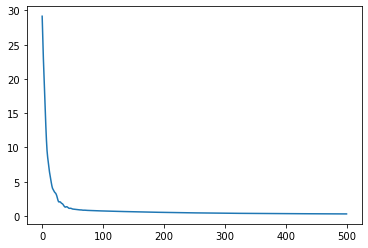

total time = 27.306640148162842


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.001,0.0762,0.0778,0.0753


In [ ]:
neuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 2,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'endpoints', 
                                   sigma = 0.01, test_size = 0.3)

### |Q|=20

#### Vote(Rand $v_Q$)

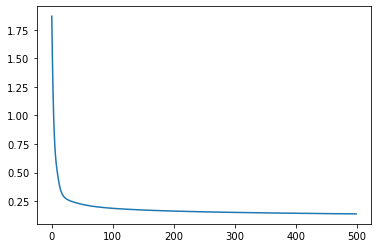

total time = 831.2375822067261


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.001,0.048,0.0637,0.0232


In [ ]:
neuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 100, test_size = 0.3)

#### Vote($v_Q^{\varsigma}$)

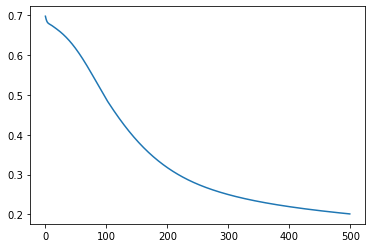

total time = 790.3821868896484


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.002,0.0657,0.1043,0.0344


In [ ]:
neuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 2e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'signed', 
                                   sigma = 100, test_size = 0.3)

#### Vote(Rand $v_Q^{exp}$)

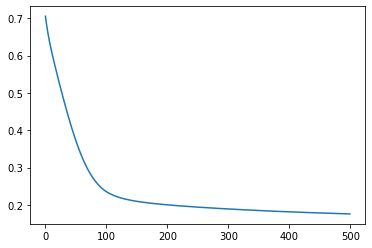

total time = 811.9109740257263


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.001,0.0551,0.0449,0.0264


In [ ]:
neuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 100, test_size = 0.3)

#### Rand($v_Q$)

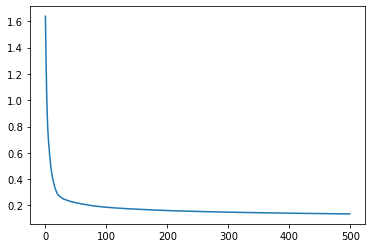

total time = 67.3783609867096


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.001,0.0474,0.0646,0.0254


In [ ]:
neuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 100, test_size = 0.3)

#### Rand($v_Q^{\varsigma}$)

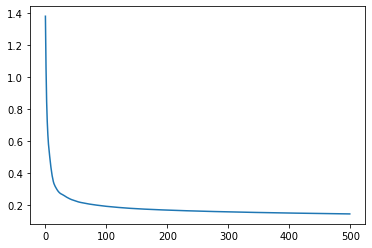

total time = 66.34213185310364


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.001,0.0504,0.0569,0.0289


In [ ]:
neuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 100, test_size = 0.3)

#### Rand($v_Q^{exp}$)

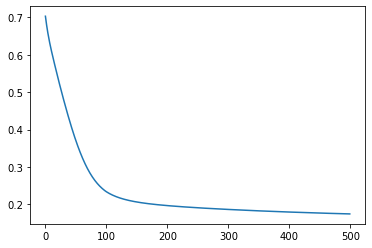

total time = 71.42929482460022


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.001,0.0532,0.0511,0.0214


In [ ]:
neuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 1,
                                   out_channels = 10, kernel_size = 5,  
                                   padding = 1, bias = True, Num_updates = 500, 
                                   D_out = 2, epoch = 50, version = 'exp', 
                                   sigma = 100, test_size = 0.3)

# Neural Network for Mistake Driven Method of Choosing Q

## Initialize Q

In [ ]:
def initialize_Q(train_1, train_2, std_coeff, out_channels, kernel_size, Q_size, 
                 padding, learning_rate = 1e-3, bias = True, D_out=2, lr_decay = 0.9, 
                 Num_updates = 100): 
        
    Q = []
    errors = []
    losses = np.zeros((Q_size - kernel_size, Num_updates))
    
    mu = get_mu(train_1, train_2)
    std = mu * std_coeff

    trajectory_train_data = np.concatenate((train_1, train_2), axis = 0)
    train_labels = np.concatenate(([1] * len(train_1), [0] * len(train_2)), 0)
    train_labels = torch.from_numpy(train_labels).long()
    index = np.random.randint(0, high=len(trajectory_train_data)) 
    k = np.random.randint(0, high=len(trajectory_train_data[index]))
    for i in range(kernel_size):
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    for i in range(Q_size - kernel_size):
        train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                            out_channels = out_channels, 
                            kernel_size = kernel_size,
                            stride  = 1,
                            padding = padding,
                            bias = bias),
                nn.ReLU(),
                #nn.LeakyReLU(0.01),
                #nn.Tanh(),
                Flatten(),
                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                            D_out)
                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
        train_data = torch.from_numpy(train_data).float()
        train_data = train_data.view(len(train_data), 1, len(train_data[0]))
        
        for k in range(Num_updates):
            x_pred = model(train_data) # of shape (N, D_out)
            loss = loss_fn(x_pred, train_labels)
            losses[i, k] = loss
            
            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
        
        train_pred = torch.argmax(model(train_data), axis=1)
        scores = model(train_data)
        I = np.where((train_labels == train_pred) == False)[0]

        temp_labels = 2 * train_labels.numpy().reshape(len(train_labels.numpy()), 1) - 1
        temp = temp_labels * scores.detach().numpy()
        temp = np.max(temp, axis=1)
        index = I[np.argmax(temp[I])]

        error = sum(train_labels != train_pred)/len(train_labels)
        errors.append(error.item())
        
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    final_error = errors[-1]

    #plt.plot((np.mean(losses, axis=0)))
    #plt.show()

    return np.array(Q), np.array(errors), mu, final_error

## Mistake Driven with CNN

In [ ]:
def MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num, epoch, init_iter, 
                                      test_size, std_coeff, out_channels, kernel_size, 
                                      Q_size, padding, learning_rate = 1e-3, 
                                      bias = True, D_out=2, lr_decay = 0.9, 
                                      Num_updates = 100):
        
    start_time = time.time()

    train_errors = np.zeros(epoch) 
    test_errors = np.zeros(epoch)

    n_1 = len(data_1)
    n_2 = len(data_2) 

    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, train_idx_2, \
        test_idx_2, train_label_2, test_label_2 = train_test(data_1, data_2, test_size)

        train = np.concatenate((data_1[train_idx_1], data_2[train_idx_2]), 0)
        test = np.concatenate((data_1[test_idx_1], data_2[test_idx_2]), 0)
        train_labels = np.concatenate((train_label_1, train_label_2), axis = 0)
        test_labels = np.concatenate((test_label_1, test_label_2), axis = 0)
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()

        x_preds = np.zeros((maj_num, len(train)))
        y_preds = np.zeros((maj_num, len(test)))
        
        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]
        
        J = np.arange(len(test))
        np.random.shuffle(J)
        test = test[J]
        test_labels = test_labels[J]

        for t in range(maj_num):

            Q_list = []
            temp_errors = []
            mu_temp = []

            for j in range(init_iter):
                B = initialize_Q(data_1[train_idx_1], data_2[train_idx_2], 
                                 std_coeff, out_channels, kernel_size, Q_size, 
                                 padding, learning_rate = 1e-3, bias = True, 
                                 D_out=2, lr_decay = 0.9, Num_updates = 100)

                Q_list.append(B[0])
                mu_temp.append(B[2])
                temp_errors.append(B[-1])

            h = np.argmin(temp_errors)
            Q = Q_list[h]
            mu = mu_temp[h]

            train_data = torch.from_numpy(ExpCurve2Vec(Q, train, mu)).float()
            train_data = train_data.view(len(train_data), 1, len(train_data[0]))

            test_data = torch.from_numpy(ExpCurve2Vec(Q, test, mu)).float()
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))

            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                    nn.ReLU(),
                    Flatten(),
                    nn.Linear(out_channels * (len(train_data[0][0]) - kernel_size + 1 + 2 * padding), 
                              D_out)
                    )
        
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)

                if (k+1) % 10 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 

            scores = model(train_data)
            
            x_preds[t] = torch.argmax(scores, axis=1).detach().numpy()
            y_preds[t] = torch.argmax(model(test_data), axis=1).detach().numpy()

        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
                            np.round(train_error_mean, decimals = 4), 
                            np.round(test_error_mean, decimals = 4),
                            np.round(test_error_std, decimals = 4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                                 columns=['Channel 1', 'Learning Rate', 
                                          'Train Error', 'Test Error', 'Std Error'])

    print(colored(f"total time = {time.time() - start_time}", "red"))
    print("mu =", mu)

    return pdf

In [ ]:
MD_NeuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, maj_num=11, epoch=50, 
                              init_iter=3, test_size=0.3, std_coeff=1, out_channels=10, 
                              kernel_size = 5, Q_size = 20, padding = 1, 
                              learning_rate = 1e-2, bias = True, D_out=2, 
                              lr_decay = 0.9, Num_updates = 100)

total time = 10732.693811893463
mu = 11.625506459216837


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0515,0.0526,0.0202


In [ ]:
MD_NeuralNetworkClassificationCNN(data1_lan_long, data2_lan_long, maj_num = 1, epoch = 50,
                                init_iter=3, test_size=0.3, std_coeff=1, out_channels=10,
                                kernel_size = 5, Q_size = 20, padding = 1, 
                                learning_rate = 1e-2, bias = True, D_out=2, 
                                lr_decay = 0.9, Num_updates = 200)

../aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


total time = 1163.1201980113983
mu = 10.594034087205586


,Channel 1,Learning Rate,Train Error,Test Error,Std Error
CNN 1-Layer,10,0.01,0.0516,0.0566,0.026


# Plot test errors

In [ ]:
def lower_limit_error(x, y):
    if y - x < 0:
        return y
    else:
        return x

lower_limit_error = np.vectorize(lower_limit_error)

In [ ]:
A_LSVM = [0.0511, 0.0785, 0.2868, 0.0735, 0.0449, 0.0892, 0.3283, 0.0751, 0.0566]
A_GSVM = [0.0575, 0.0597, 0.0892, 0.0658, 0.0625, 0.0625, 0.1102, 0.0658, 0.0523]
A_PSVM = [0.0655, 0.0622, 0.2197, 0.0615, 0.0683, 0.0668, 0.2262, 0.0609, 0.0677]
A_DT = [0.0735, 0.0806, 0.0963, 0.0714, 0.0877, 0.1037, 0.1314, 0.0889, 0.1185]
A_RF = [0.0625, 0.0625, 0.0769, 0.0628, 0.0658, 0.0692, 0.0892, 0.0637, 0.0655]
A_KNN = [0.0566, 0.0542, 0.0825, 0.0538, 0.0483, 0.0578, 0.0963, 0.0523, 0.0514]
A_LR = [0.0492, 0.0572, 0.3492, 0.0572, 0.0502, 0.0631, 0.3462, 0.0548, 0.0588]
A_CNN = [0.0526, 0.0637, 0.1043, 0.0449, 0.0566, 0.0646, 0.0569, 0.0511, 0.0778]

A = np.array([A_LSVM, A_GSVM, A_PSVM, A_DT, A_RF, A_KNN, A_LR, A_CNN])
B = A.T

In [ ]:
std_LSVM = [0.0216, 0.0323, 0.0490, 0.0239, 0.0259, 0.0326, 0.0725, 0.0616, 0.0231]
std_GSVM = [0.0238, 0.0203, 0.0287, 0.0267, 0.0286, 0.0212, 0.0367, 0.0783, 0.0222]
std_PSVM = [0.0271, 0.0257, 0.0562, 0.0215, 0.0302, 0.0259, 0.0673, 0.0692, 0.0265]
std_DT = [0.0294, 0.0301, 0.0293, 0.0250, 0.0289, 0.0384, 0.0358, 0.0812, 0.0354]
std_RF = [0.0254, 0.0296, 0.0263, 0.0238, 0.0263, 0.0263, 0.0234, 0.0857, 0.0224]
std_KNN = [0.0214, 0.0209, 0.0330, 0.0214, 0.0222, 0.0217, 0.0342, 0.0521, 0.0212]
std_LR = [0.0238, 0.0246, 0.0495, 0.0230, 0.0250, 0.0243, 0.0612, 0.0620, 0.0225]
std_CNN = [0.0202, 0.0232, 0.0344, 0.0264, 0.0260, 0.0254, 0.0289, 0.0214, 0.0753]

C = np.array([std_LSVM, std_GSVM, std_PSVM, std_DT, std_RF, std_KNN, std_LR, std_CNN]).T

In [ ]:
errors = [0.0554, 0.0582, 0.0526, 0.0591, 0.0538, 0.0748, 0.0646, 0.3274, 0.1252, 
          0.0569, 0.0566]

stds = [0.0226, 0.0252, 0.0213, 0.0212, 0.0231, 0.0277, 0.0218, 0.1287, 0.0345, 
        0.0227, 0.0221]

In [ ]:
classifiers = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

FM = (r'KNN', r'Vote(MD $v_Q^{exp}$)', r'Vote(Rand $v_Q$)', r'Vote($v_Q^{\varsigma}$)', 
      r'Vote(Rand $v_Q^{exp}$)', r'MD $v_Q^{exp}$', r'Rand $v_Q$', 
      r'Rand $v_Q^{\varsigma}$', r'Rand $v_Q^{exp}$', 'Endpoints')

labels = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

dists = [r'$d_{dF}$', r'$dH$', r'DTW', r'soft-dtw', r'fastdtw', 
         r'LCSS', r'SSPD', r'EDR', r'ERP', r'LSH', r'$d_Q^{\pi}$']

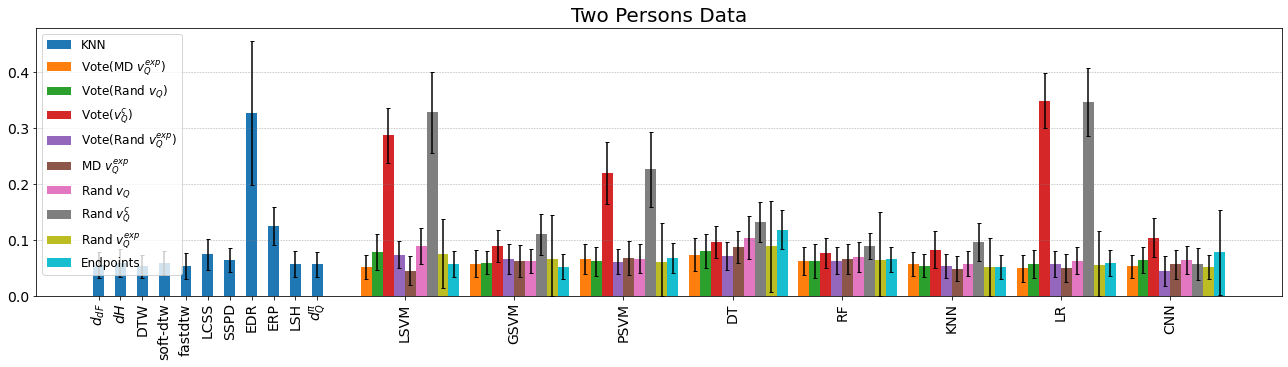

In [ ]:
width=0.1
index = np.arange(len(stds))
ind = np.arange(len(A)) + len(index) * 0.25

plt.subplots(figsize = (18, 5.2), tight_layout=True)
bars = [0] * 10

lower_lim = lower_limit_error(stds, errors)
bars[0] = plt.bar(index * 0.2, errors, width, yerr=[lower_lim, stds], capsize=2)

for i in range(len(FM)-1):
    lower_limit = lower_limit_error(C[i], B[i])
    bars[i+1] = plt.bar(ind+width*i-0.3, B[i], width, yerr=[lower_limit, C[i]], capsize=2)

plt.title('Two Persons Data', fontsize = 20)
plt.xticks(list(np.arange(len(stds)) * 0.2) + list(ind + 0.5 * width), 
           dists + labels, fontsize = 14)

plt.legend(tuple(bars), FM, loc=0, fontsize = 12)

plt.gca().yaxis.grid(color='gray', linestyle='dotted', linewidth=0.6)
plt.xticks(rotation='vertical', fontsize = 14)
plt.yticks(fontsize = 14)

path = '/content/gdrive/My Drive/Research/plots/plots two persons/Two persons bar chart all horizontal.png'

plt.savefig(path, bbox_inches='tight', dpi=200)

plt.show()
